# Проект исследования оттока клиентов регионального банка

**Цель работы:** выявить клиентов, склонных к уходу. Это позволить банку проработать дополнительные стимулы для работы с такими клиентами и уменьшить отток.  
**Решаемая задача:** на основании представленных данных поведения клиентов (срез на 01.03.2023, данные за февраль 2023) выделить портреты клиентов, склонных к уходу.  
**Заказчик:** Продакт-менеджер.

**План работы (декомпозиция задачи):**

1. **Предобработка данных.**   
Знакомство с данными и приведением их в порядок: удаление дубликатов, поиск пропусков, проверка типов данных и т.д.  
  
  
2. **Исследовательский анализ данных.**   
Включает в себя поиск закономерностей и аномалий. На этом этапе потребуется разбить часть колонк на подкатегории, т.е. провести сегментацию. Колонки, которые точно требуется сегментировать: Age, City, Estimated_salary, Balance. Потребуется посмотреть корреляцию между различными факторами (возраст, наличие собственности и т.п.) и уходом клиентов (Churn).  


3.  **Проверка гипотез для составления портрета клиента.**  
- Средние значениях доходов ушедших клиентов и тех, кто остались не отличаются.
- Средние значение кредитного рейтинга (score) ушедших и оставшихся клиентов не отличаются.  
Гипотезы могут быть уточнены или изменены по итогу работы над п.2. Выбор статистического метода также зависит от п.2.


4. **Написание выводов из полученных результатов проверок гипотез и исследовательского анализа**.   
На этом этапе потребуется составить финальный портрет клиентов, склонных к уходу.


5. **Предоставление результатов заказчику**. Заказчик в нашем случае - продакт-менеджер, а предоставлять результаты будем в виде презентации.



# Оглавление
**1. [Извлечение и знакомство с данными](#start)  
2. [Предобработка данных](#Data_preprocessing)    
3. [Исследовательский анализ](#analysis)  
 3.1 [Исследования корреляции](#corr)  
 3.2 [Првоерка гипотез](#check)  
 3.3 [Анализ категорий клиентов, склонных к уходу](#portret)  
4. [Выводы и рекомендации](#conclusion)**


# 1. Извлечение и знакомство данных <a id="start"></a>  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import phik
from phik.report import plot_correlation_matrix
from phik import report
import seaborn as sns
import math as mth
import warnings

In [2]:
path = "https://drive.google.com/uc?export=download&id=1-U61mhTz_N1ARjy2XSAZ7IlQqGjeqP0F" 

In [3]:
try:
    data = pd.read_csv('C:/Users/zvere/Desktop/Яндекс Практикум/Выпускной проект/bank_scrooge.csv')
except:
    data = pd.read_csv(path)

In [4]:
data.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


1. Всего 10000 записей в датасете
2. Столбец age и balance имеют пропуски. Если у первого их совсем немного, то balance указан менее чем в 80% случаев
3. Типы данных приведены адекватно. Для того, чтобы не работать с копейками приведём колонки balance, est_salary к int. Age тоже.

In [6]:
data.describe()

,USERID,score,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
count,10000.00000,10000.000000,9974.000000,10000.000000,7.705000e+03,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,171814.71260,848.699400,42.734409,2.627600,8.277943e+05,1.870100,0.680400,0.523500,1.478669e+05,0.182000
std,33708.23812,65.448519,12.179971,1.980836,1.980614e+06,0.792647,0.466345,0.499472,1.393885e+05,0.385864
min,94561.00000,642.000000,18.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.546300e+03,0.000000
25%,142810.25000,802.000000,33.000000,0.000000,2.955542e+05,1.000000,0.000000,0.000000,7.525190e+04,0.000000
50%,172728.00000,853.000000,40.000000,3.000000,5.242722e+05,2.000000,1.000000,1.000000,1.196581e+05,0.000000
75%,201261.75000,900.000000,51.000000,4.000000,9.807058e+05,2.000000,1.000000,1.000000,1.745005e+05,0.000000
max,229145.00000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000


<div style="border:solid Gold; padding: 40px"> 
    
Данные в целом выглядят корректно:   
- Баллы кредитного скорринга от 642 (что достаточно низко) и до 1000 (допустим, что эо максимальный балл).  
- Возраст от 18 до 86, средний возраст 42 года.  
- В собственности у клиентов от 0 до 9 объектов.  
- В среднем пользуются 1,8 продуктом банка.
- Видно, что есть аномально низкие зарплаты.

# 2. Предобработка данных <a id="Data_preprocessing"></a> 

**Изменим наименования столбцов, т.к. в текущем формате работать с ними неудобно**

In [7]:
data.rename(columns = {'USERID':'user_id', 'EST_SALARY':'est_salary'}, inplace = True)

Округлим зарплаты и балансы, т.к. копейки нам не интересны

In [8]:
data['balance'] = data['balance'].round()
data['est_salary'] = data['est_salary'].round()

**Проверим наличие дубликатов**

In [9]:
data.duplicated().sum()

0

Явные дубликаты отсутствуют

**Попытаемся понять, что может быть скрыто за пропусками в balance**

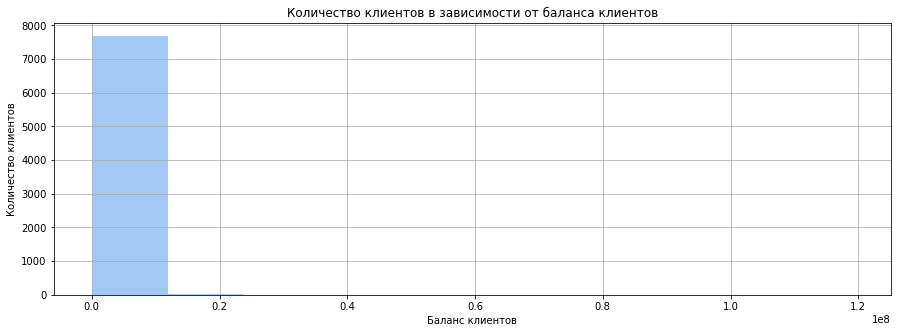

In [10]:
sns.set_palette('pastel')
data['balance'].hist(bins=10, figsize=(15,5)) 
plt.title('Количество клиентов в зависимости от баланса клиентов')
plt.xlabel('Баланс клиентов')
plt.ylabel('Количество клиентов')
plt.show()

Большинство балансов находятся в диапазоне до 1 млн.р. Посмотрим, сколько клиентов имеют балансы свыше 500 т.р., 1 млн, 5 млн и 10 млн

In [11]:
print(f'количество клиентов с балансом более 500т.р. -', data['balance'][data['balance'] > 500000].count())
print(f'количество клиентов с балансом более 1 млн.р. -', data['balance'][data['balance'] > 1000000].count())
print(f'количество клиентов с балансом более 5 млн.р. -', data['balance'][data['balance'] > 5000000].count())
print(f'количество клиентов с балансом более 10 млн.р. -', data['balance'][data['balance'] > 10000000].count())

количество клиентов с балансом более 500т.р. - 4004
количество клиентов с балансом более 1 млн.р. - 1876
количество клиентов с балансом более 5 млн.р. - 73
количество клиентов с балансом более 10 млн.р. - 27


Ввиду совсем небольшого количества клиентов с балансом больше 10 млн.р. удалим их из анализа, так как для статистического анализа 27 - слишком мало, чтобы говорить о каких то результатах, при этом они будут в дальнейшем давать слишком большие выбросы

In [12]:
data = data.query('balance < 10000000 | balance.isnull()', engine='python')
data.shape[0]

9973

In [13]:
data[data['balance'] == 0]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
3900,179831,730.0,Ярославль,М,18.0,0,0.0,2,1,1,64548.0,0
6757,148456,813.0,Ярославль,М,20.0,2,0.0,2,1,0,23877.0,0


То, что есть клиенты с нулевым балансом говорит о том, что пропуск значения НЕ является нулевым балансом. 
Предположим, что значение Nan в балансе является показателем наличия задолженности на счету из-за просрочки по кредитной карте.

Посмотрим, сколько Nan в столбце balance при наличии кредитной карты

In [14]:
data[(data['credit_card'] == 1)].count()

user_id          6791
score            6791
city             6791
gender           6791
age              6771
equity           6791
balance          4919
products         6791
credit_card      6791
last_activity    6791
est_salary       6791
churn            6791
dtype: int64

Почти 80% пропусков попадают под это условие.

In [15]:
warnings.filterwarnings('ignore')
data[(data['credit_card'] == 1) & (data['churn'] == 1)][data['balance'].isna()].head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1273,136567,961.0,Ярославль,М,31.0,0,NaN,1,1,0,1015386.0,1
1400,146876,707.0,Ярославль,М,24.0,0,NaN,3,1,0,94091.0,1
3017,123230,980.0,Рыбинск,Ж,53.0,0,NaN,1,1,1,327646.0,1
4118,157443,727.0,Ростов,М,69.0,0,NaN,1,1,0,132547.0,1
4302,167482,955.0,Ярославль,М,62.0,0,NaN,1,1,0,157785.0,1


 Скорей всего отрицательный баланс даёт Nan в столбце, в связи с чем пропуски в этом столбце мы заполнять не будем - оставляем, как есть. Возможно, это не баг, а фича! Других аномалий найти не удалось

Есть предположение, что люди без собственности и с просроченными кредитками редко уходят из банка. Проврим позднее.

**Посмотрим на указанные зарплаты**

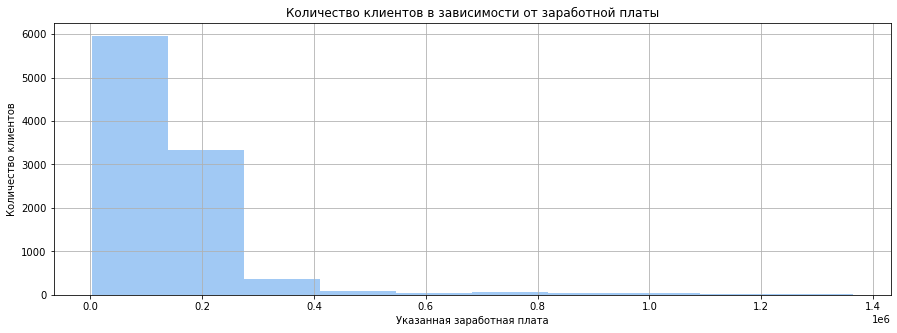

In [16]:
data['est_salary'].hist(bins=10, figsize=(15,5))
plt.title('Количество клиентов в зависимости от заработной платы')
plt.xlabel('Указанная заработная плата')
plt.ylabel('Количество клиентов')
plt.show()

Посмотрим кол-во пользователей, имеющих зарплату ниже МРОТ и удалим их

In [17]:
MPOT = 16242 #минимальная оплата труда в России в 2023 году

In [18]:
data.query('est_salary < @MPOT')['est_salary'].count()

80

In [19]:
print(f'количество клиентов с указанной зарплатой более 100т.р. -', data['est_salary'][data['est_salary'] > 100000].count())
print(f'количество клиентов с указанной зарплатой более 1 млн.р. -', data['est_salary'][data['est_salary'] > 1000000].count())

количество клиентов с указанной зарплатой более 100т.р. - 6043
количество клиентов с указанной зарплатой более 1 млн.р. - 52


С зарплатами схожая история: большинство людей имеют ЗП более 100 000 тысяч рублей. Большие ЗП (больше 1 млн) имеют небольшое кол-во человек (52), но чтобы убрать сильные выбросы мы удалим их из датасета. 

При этом это поле не обязательно отражает действительность, мы не можем быть уверены, что в нём корректно отражены ЗП клиентов.

In [20]:
data = data.query('est_salary > @MPOT & est_salary < 1000000')

**Проанализируем кредитный рейтинг клиентов**

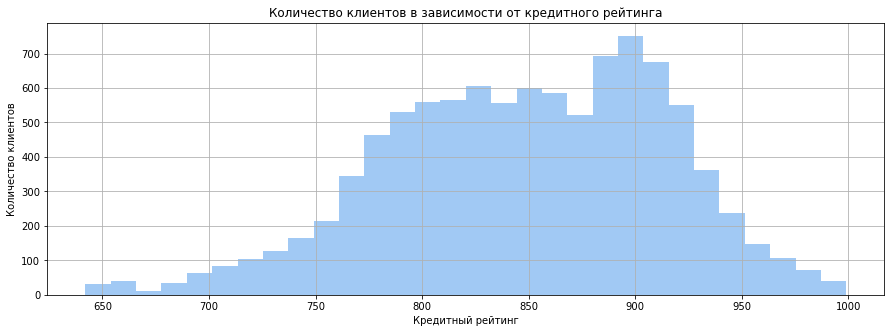

In [21]:
data['score'].hist(bins=30, figsize=(15,5))
plt.title('Количество клиентов в зависимости от кредитного рейтинга')
plt.xlabel('Кредитный рейтинг')
plt.ylabel('Количество клиентов')
plt.show()

Распределение баллов кредитного скоринга напоминает нормальное, аномалий не видно

**Рассмотрим возраст клиентов**

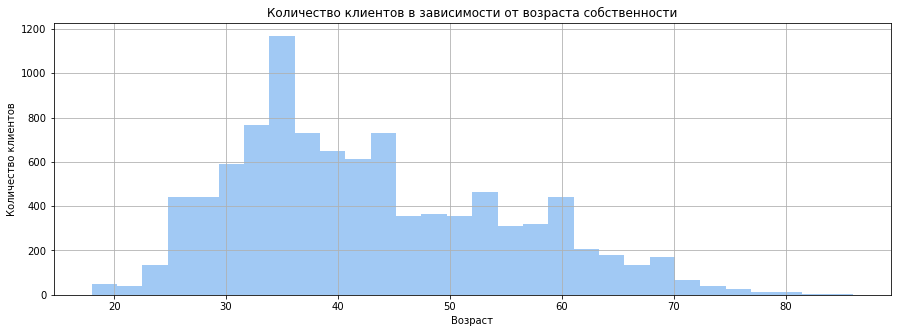

In [22]:
data['age'].hist(bins=30, figsize=(15,5))
plt.title('Количество клиентов в зависимости от возраста собственности')
plt.xlabel('Возраст')
plt.ylabel('Количество клиентов')
plt.show()

30-45 наиболее распространенный возраст для клиентов банка, аномалий не обнаружено

**Изучим наличие собственности у клиентов**

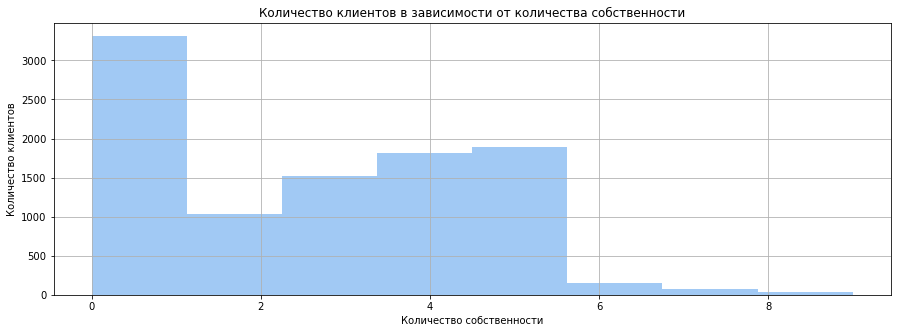

In [23]:
data['equity'].hist(bins=8, figsize=(15,5))
plt.title('Количество клиентов в зависимости от количества собственности')
plt.xlabel('Количество собственности')
plt.ylabel('Количество клиентов')
plt.show()

У большинства нет никакой собственности. Что любопытно, что на втором месте люди, у которых аж 5 объектов в собственности.

**Посмотрим на распределение по городам**

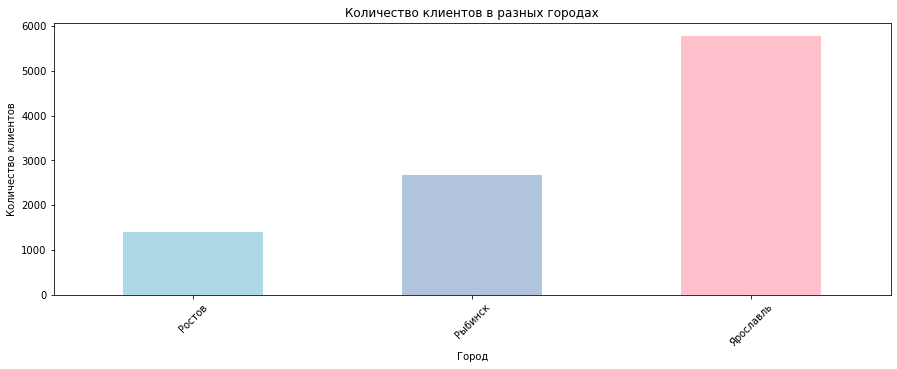

In [24]:
data.groupby('city')['user_id'].count().plot(kind='bar', figsize=(15,5), color=['lightblue', 'lightsteelblue', 'pink'])
plt.xticks(rotation=45)
plt.title('Количество клиентов в разных городах')
plt.xlabel('Город')
plt.ylabel('Количество клиентов')
plt.show()

Большинство клиентов в Ярославле. В Ростове клиентов меньше всего

**Посмотрим на кол-во используемых продуктов**

In [25]:
data['products'].value_counts()

2    5042
1    3293
3    1020
4     466
5      19
0       1
Name: products, dtype: int64

Клиентов с 0 продуктов быть не может (даже тех, кто ушёл) - скорей всего это какая то ошибка. Удалим это значение

In [26]:
data = data.query('products != 0')

**Посмотрим на наличие у людей кредитных карт и их активность**

In [27]:
data['credit_card'].value_counts()

1    6691
0    3149
Name: credit_card, dtype: int64

In [28]:
data['last_activity'].value_counts()

1    5150
0    4690
Name: last_activity, dtype: int64

Большинство клиентов имет кредитные карты. При этом только около половины была активна за последний отчётный период

**Посмотрим на распределение по гендерному признаку**

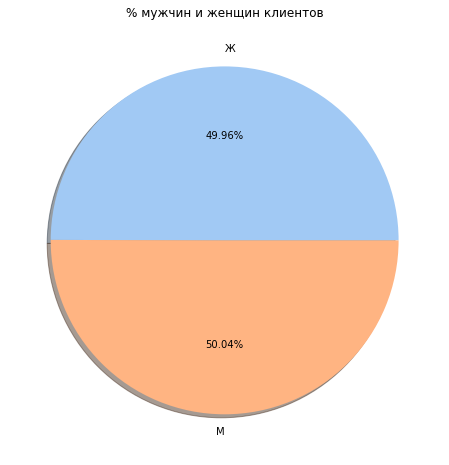

In [29]:
sns.set_palette('pastel')
data.groupby('gender').size().plot(kind='pie', subplots=True, figsize=(8, 8), autopct='%1.2f%%', shadow=True)
plt.title("% мужчин и женщин клиентов")
plt.ylabel("")
plt.show()

Мужчин и женщин примерно поровну

**Проверим на наличие неявных дубликатов**

In [30]:
data.shape[0]

9840

In [31]:
data['user_id'].value_counts().sort_values(ascending=False)

149365    2
220816    2
187635    2
210135    2
131419    2
         ..
150126    1
120403    1
160702    1
212027    1
96267     1
Name: user_id, Length: 9768, dtype: int64

In [32]:
data['user_id'].nunique()

9768

72 user_id имеют по 2 строки в дата сете

In [33]:
user_duplicated = data[data['user_id'].duplicated(keep=False)].sort_values(by='user_id')
user_duplicated.tail(6)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
8070,226550,940.0,Рыбинск,М,NaN,0,NaN,1,0,1,147697.0,0
6412,226550,939.0,Ярославль,М,34.0,0,NaN,1,1,1,145914.0,0
8497,227795,839.0,Ярославль,М,34.0,2,326593.0,2,1,0,103315.0,0
8205,227795,840.0,Рыбинск,М,34.0,2,350768.0,1,1,0,102036.0,1
1247,228075,932.0,Ярославль,М,NaN,5,7601719.0,2,1,1,408121.0,0
6457,228075,839.0,Рыбинск,М,39.0,5,507200.0,3,0,1,85196.0,0


In [34]:
user_duplicated['churn'].value_counts()

0    95
1    49
Name: churn, dtype: int64

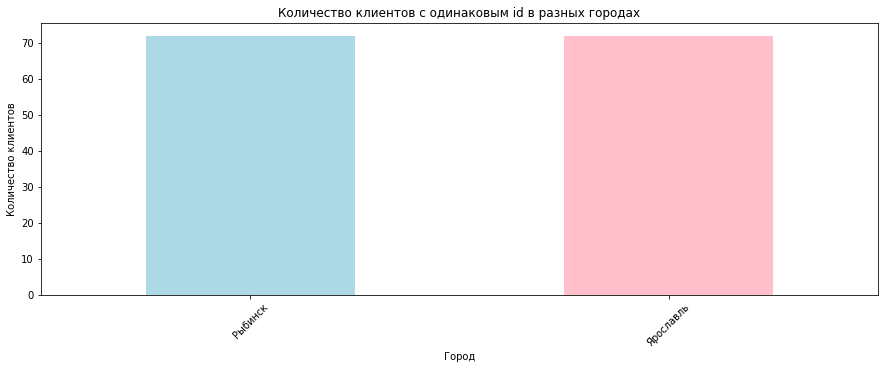

In [35]:
user_duplicated.groupby('city')['user_id'].count().plot(kind='bar', figsize=(15,5), color=['lightblue', 'pink'])
plt.xticks(rotation=45)
plt.title('Количество клиентов с одинаковым id в разных городах')
plt.xlabel('Город')
plt.ylabel('Количество клиентов')
plt.show()

Получается достаточно любопытно: 
1. всего 72 человека с повторяющимеся ID
2. клиенты, с одинаковыми user_id равномерно распределены между Ярославлем и Рыбинском.
3. при этом мы не можем сказать, что эти клиенты просто перешли из банка одного города в другой, т.к. ушедших -49, в том время как оставшихся - 95.
4. по данным видно, что есть случаи, когда люди с одинаковыми id имеют счета в банках в Рыбинске и Ярославле, при этом они не уходили из банков
5. по некоторым клиентам видно, что это один и тот же человек имеет два счёта в разных городах, однако по некоторым нельзя с уверенностью сказать, что это одни и те же люди, так как у них отличается пол, возраст, кол-во объектов в собственности.
6. любопытно, что у пользователей (даже тех, кого можно подозревать в том, что это один и тот же клиент) разная оценка в кредитного скоринга. Возможно, часть людей открывают счёт в соседнем городе с целью получения кредита.
7. необходимо обратить внимание менеджеров банка на этот момент

Итого: неявные дубликаты оставляем, так как мы не можем быть уверены во всех случаях, что это одни и те же люди. Кроме того эти клиенты могут быть полезны в составлении портретов клиентов

Посчитаем процент датасета, который мы исключили в ходе предобработки:

In [36]:
print(f'процент удаленных данных из изначального датасета:',((10000 - data.shape[0]) / 10000) *100)
print(f'кол-во строк в датасете по итогам предобработки:', data.shape[0])

процент удаленных данных из изначального датасета: 1.6
кол-во строк в датасете по итогам предобработки: 9840


<div style="border:solid Gold; padding: 40px"> 
    
**Итоги предобработки предобработки:**  
    
1. Изначально в датасете было 10000 строк. 
2. В ходе предобработки мы удалили около 1,6% информации из дасатета, ввиду выбросов и недостовернных данных.
3. Явных дубликатов не обнаружено.
4. Были удалены строки с крайне высокими балансами и зарплатами, т.к. они могли повлиять на дальнейшие исследования.
5. Существуют неявные дубликаты в колонке user_id, но так как их природу установить не удалось - их оставили.
6. Пропуски в колонках balance и age оставили, т.к. не до конца понятно, чем они вызваны. Есть предположение, что пропуски в 5. balance это просрочка по кредитами или отрицательный баланс. Каких-либо связей между пропусками и другими данными установить не удалось.

# 3. Исследовательский анализ <a id="analysis"></a> 


**Приступим к исследованию данных с рассмотрения различных факторов для ушедших и оставшихся клиентов**

In [37]:
pd.set_option('display.max_columns', None)
data.groupby('churn').agg(['count', 'median', 'mean']).round()

user_id                     score                 age               \
        count    median      mean count median   mean count median  mean   
churn                                                                      
0        8043  173189.0  171986.0  8043  848.0  845.0  8018   40.0  43.0   
1        1797  170745.0  170925.0  1797  866.0  863.0  1796   39.0  41.0   

      equity             balance                      products              \
       count median mean   count    median       mean    count median mean   
churn                                                                        
0       8043    3.0  2.0    5799  476746.0   671239.0     8043    2.0  2.0   
1       1797    4.0  4.0    1786  775349.0  1015836.0     1797    2.0  2.0   

      credit_card             last_activity             est_salary            \
            count median mean         count median mean      count    median   
churn                                                                          
0            8043    1.0  1.0          8043    0.0  0.0       8043  118418.0   
1            1797    1.0  1.0          1797    1.0  1.0       1797  124997.0   

                 
           mean  
churn            
0      142206.0  
1      142216.0

При первичном анализе данных можно сделать следующие выводы:
1. Ушедших клиентов в 4,5 раза меньше, чем оставшихся
2. Медианный кредитный score у ушедших немного выше.
3. Медианный возраст примерно одинаковый
4. Уходят люди с бОльшим кол-во собственности
5. Уходят люди с бОльшими балансами и бОльшими зарплатами
6. Для balance и est_salary большая разница между средними и медианными значениями из за выбросов. Оставили выбросы, т.к. банку интересны люди с большими балансами и зарплатами.

Посмотрим среднее значение оттока клиентов

In [38]:
churn_mean = round(data['churn'].mean(),2)
churn_mean

0.18

То есть в среднем 18% процентов клиентов уходят из банка. Кажется, это достаточно много. Будем использовать это значение для определения портретов клиентов, склонных к оттоку

Создадим для работы два отдельных датасета с ушедшими и оставшимися клиентами

In [39]:
data_non_churn = data[data['churn'] == 0]
data_churn = data[data['churn'] == 1]

Взглянем на клиентов по городам

In [40]:
data_city = data.pivot_table(index='churn', columns='city', values='age', aggfunc='count')
data_city.loc['ratio'] = data_city.loc[1] / data_city.loc[0]
data_city

city,Ростов,Рыбинск,Ярославль
churn,,,
0,1129.000000,2219.000000,4670.000000
1,261.000000,435.000000,1100.000000
ratio,0.231178,0.196034,0.235546


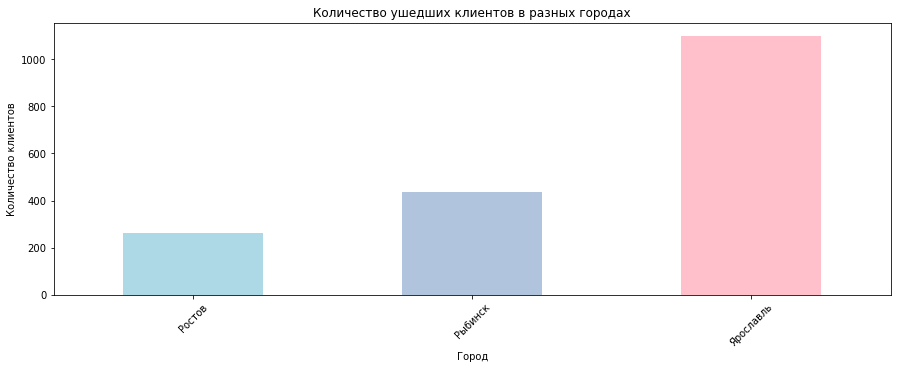

In [41]:
data_churn.groupby('city')['user_id'].count().plot(kind='bar', figsize=(15,5), color=['lightblue', 'lightsteelblue', 'pink'])
plt.xticks(rotation=45)
plt.title('Количество ушедших клиентов в разных городах')
plt.xlabel('Город')
plt.ylabel('Количество клиентов')
plt.show()

Больше всего в абсолютном выражении  уходят из Ярославля.
В относительном выражении из Ярославля и Ростова уходят прмиерно одинаково. Рыбинск наименее отточный город

In [42]:
data_gender = data.pivot_table(index='churn', columns='gender', values='age', aggfunc='count')
data_gender.loc['ratio'] = data_gender.loc[1] / data_gender.loc[0]
data_gender

gender,Ж,М
churn,,
0,4272.00000,3746.000000
1,632.00000,1164.000000
ratio,0.14794,0.310731


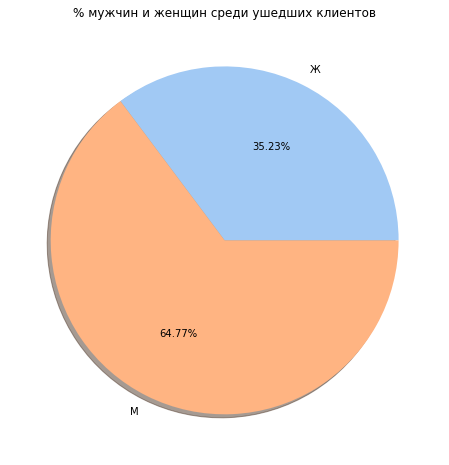

In [43]:
sns.set_palette('pastel')
data_churn.groupby('gender').size().plot(kind='pie', subplots=True, figsize=(8, 8), autopct='%1.2f%%', shadow=True)
plt.title("% мужчин и женщин среди ушедших клиентов")
plt.ylabel("")
plt.show()

Значительно больше уходят мужчины, чем женщины как в абсолютном, так и в относительном выражении

# 3.1 Исследование корреляции <a id="corr"></a>  

Приведём все столбцы к бинарному виду

In [44]:
data_n = pd.get_dummies(data)
data_n.rename(columns = {'city_Ростов':'city_rostov', 'city_Рыбинск':'city_rybinsk', 'city_Ярославль':'city_yaroslavl', 'gender_Ж':'gender_female', 'gender_М':'gender_male' }, inplace = True)
data_n.head()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_rostov,city_rybinsk,city_yaroslavl,gender_female,gender_male
0,183012,850.0,25.0,1,59215.0,2,0,1,75719.0,1,0,1,0,1,0
1,146556,861.0,37.0,5,850594.0,3,1,0,86622.0,0,0,1,0,1,0
2,120722,892.0,30.0,0,NaN,1,1,1,107683.0,0,0,1,0,1,0
3,225363,866.0,51.0,5,1524746.0,2,0,1,174424.0,1,0,0,1,1,0
4,157978,730.0,34.0,5,174.0,1,1,0,67353.0,1,0,0,1,0,1


Посмотрим на корреляцию между уходом клиентов и другими факторами при помощи параметра Phik. Выбрали именно этот метод корреляции, так как он хорошо работает с категориальными переменными, в том числа бинарными 

In [45]:
phik_overview1 = data_n.phik_matrix()
phik_overview1.round(2)

interval columns not set, guessing: ['user_id', 'score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'est_salary', 'churn', 'city_rostov', 'city_rybinsk', 'city_yaroslavl', 'gender_female', 'gender_male']


,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_rostov,city_rybinsk,city_yaroslavl,gender_female,gender_male
user_id,1.00,0.07,0.00,0.07,0.05,0.10,0.04,0.06,0.00,0.14,0.04,0.00,0.00,0.06,0.06
score,0.07,1.00,0.05,0.53,0.40,0.42,0.21,0.05,0.38,0.23,0.08,0.01,0.07,0.07,0.07
age,0.00,0.05,1.00,0.04,0.18,0.14,0.15,0.09,0.39,0.18,0.07,0.05,0.09,0.28,0.28
equity,0.07,0.53,0.04,1.00,0.34,0.58,0.22,0.05,0.30,0.35,0.06,0.00,0.05,0.06,0.06
balance,0.05,0.40,0.18,0.34,1.00,0.24,0.20,0.02,0.66,0.29,0.06,0.02,0.07,0.08,0.08
products,0.10,0.42,0.14,0.58,0.24,1.00,0.27,0.11,0.23,0.26,0.04,0.09,0.11,0.07,0.07
credit_card,0.04,0.21,0.15,0.22,0.20,0.27,1.00,0.05,0.04,0.20,0.15,0.08,0.18,0.19,0.19
last_activity,0.06,0.05,0.09,0.05,0.02,0.11,0.05,1.00,0.03,0.26,0.00,0.08,0.08,0.02,0.02
est_salary,0.00,0.38,0.39,0.30,0.66,0.23,0.04,0.03,1.00,0.06,0.13,0.08,0.15,0.14,0.14
churn,0.14,0.23,0.18,0.35,0.29,0.26,0.20,0.26,0.06,1.00,0.00,0.05,0.03,0.22,0.22


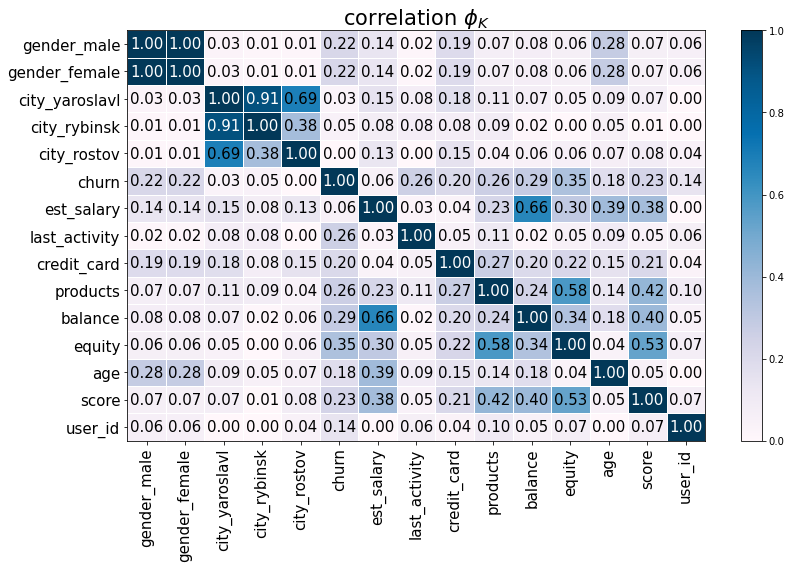

In [46]:
plot_correlation_matrix(phik_overview1.values, 
                        x_labels=phik_overview1.columns, 
                        y_labels=phik_overview1.index, 
                        vmin=0, vmax=1, color_map="PuBu", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(12, 8))
plt.tight_layout()

<div style="border:solid Gold; padding: 40px">  
    
Ярко выраженная (сильная) корреляция между уходом клиентов и другими факторами отсутствует.  
    
Согласно шкале Чеддока есть умеренная корреляция с  equity.  
    
Между зарплатой, городом и уходом клиента почти нет никакой связи.  
    
При этом существует слабая корреляция с кол-ом продуктов, активностью, наличием кредитки, возрастом, полом и кредитным рейтингом.


Проверим себя, применив корреляци Пирсена

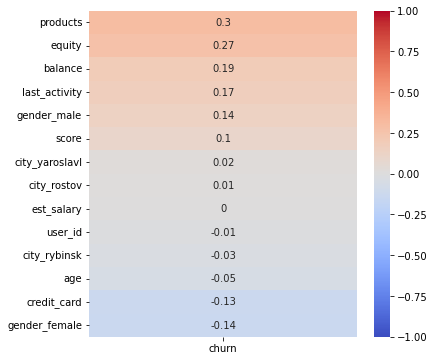

In [47]:
plt.figure(figsize = (6,6))
sns.heatmap(data_n.corr().loc[:,['churn']].round(2).drop('churn').sort_values('churn', ascending=False), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')
plt.show()

Картина схожа, хоть и отличается.
Существует умеренная корреляция для кол-ва продуктов и собственности, в остальном либо слабая корреляция, либо её отсутствие.


<div style="border:solid Gold; padding: 40px"> 
Таким образом, прямой и сильной связи между уходом клиента и другими факторами обнаружить не удалось.



# 3.2 Проверка гипотез <a id="check"></a>  

Присутпим к работе со статистическими гипотезами, их в нашем случае будет две:
1) **Средние значениях доходов ушедших клиентов и тех, кто остались не отличаются**   
2) **Средние значение кредитного рейтинга (score) ушедших и оставшихся клиентов не отличаются**


***Гипотеза №1***  
Н0: Средние значениях доходов ушедших клиентов и тех, кто остались не отличаются.   
Н1: Существует различия между средними значениями дохода клиентов, которые ушли и которые остались.  
Выбираем p урвоень значимости равный 0.05.  
Будет использовать двухсторонний тест, так как нам неважно в какую сторону могут быть отличия.  


Посмотрим на столбец est_salary внимательней

In [48]:
data.groupby('churn')['est_salary'].agg(['count', 'median', 'mean']).round()

,count,median,mean
churn,,,
0,8043,118418.0,142206.0
1,1797,124997.0,142216.0


Построим графики для изучения распределния в столбце est_salary

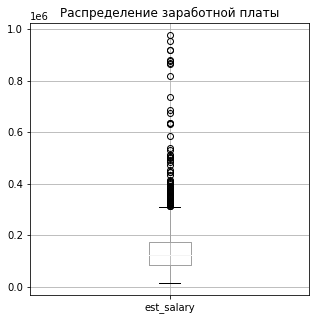

In [49]:
data_churn.boxplot('est_salary', figsize=(5, 5))
plt.title('Распределение заработной платы')
plt.show()

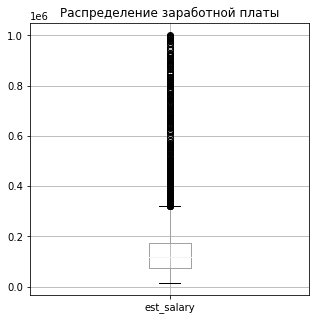

In [50]:
data_non_churn.boxplot('est_salary', figsize=(5, 5))
plt.title('Распределение заработной платы')
plt.show()

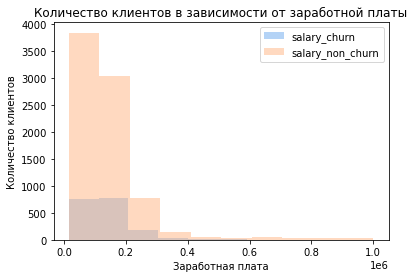

In [51]:
plt.hist(data_churn['est_salary'], alpha=0.8, label='salary_churn')
plt.hist(data_non_churn['est_salary'], alpha=0.5, label='salary_non_churn')
plt.legend(loc='upper right')
plt.rcParams["figure.figsize"] = (10,8)
plt.title('Количество клиентов в зависимости от заработной платы')
plt.xlabel('Заработная плата')
plt.ylabel('Количество клиентов')
plt.show() 

Распределение явно носит не нормальный вид. Имеется большой хвост. На графиках boxplot видно большое количество выбросов, что для зарплат - нормальное явление.

Посмотрим выборочное среднее для ушедших и не ушедших пользователей, чтобы понять можем ли мы применить t test

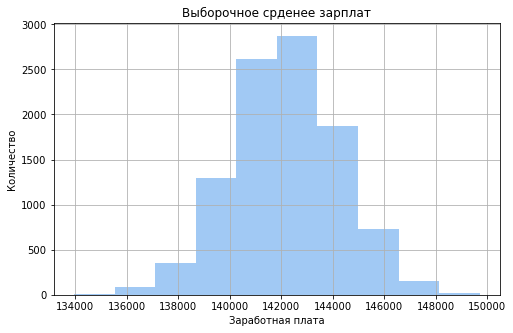

In [52]:
mean_of_data_churn = []
for _ in range(10000):
    mean_of_data_churn.append(data_churn['est_salary'].sample(1000).mean())
plt.rcParams["figure.figsize"] = (8,5)
pd.Series(mean_of_data_churn).hist()
plt.title('Выборочное срденее зарплат')
plt.xlabel('Заработная плата')
plt.ylabel('Количество')
plt.show()

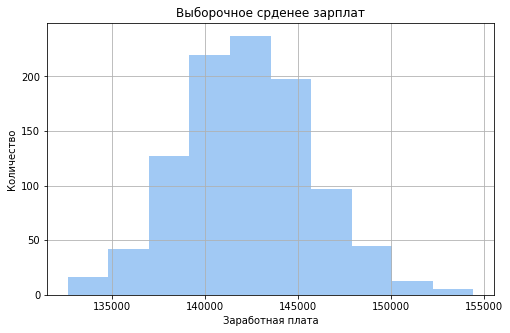

In [53]:
mean_of_data_non_churn = []
for _ in range(1000):
    mean_of_data_non_churn.append(data_non_churn['est_salary'].sample(1000).mean())
plt.rcParams["figure.figsize"] = (8,5)
pd.Series(mean_of_data_non_churn).hist()
plt.title('Выборочное срденее зарплат')
plt.xlabel('Заработная плата')
plt.ylabel('Количество')
plt.show()

Распределние выборочных средних похоже на нормальное, проверим используя тест Шапиро-Уилка

In [54]:
import warnings
warnings.filterwarnings('ignore')

alpha = 0.05 
results = st.shapiro(mean_of_data_churn)
results1 = st.shapiro(mean_of_data_non_churn)
p_value = results[1]  
p_value1 = results1[1]  
print('p-значение data_churn: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')
    
print('p-значение data_non_churn: ', p_value1)
if p_value1 < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

p-значение data_churn:  0.15653495490550995
Не получилось отвергнуть нулевую гипотезу, всё нормально
p-значение data_non_churn:  0.044144172221422195
Отвергаем нулевую гипотезу: распределение не нормально


Очевидно, что большие выбросы влияют на выборку в non churn сегменте. Тем не менее будем считать, что требование к нормальности выборок удовлетворено

Видно большое количество "выбросов" на графике зарплат. Максимальные зарплаты сильно отличаются от медианных значений и даже тех, которые относятся к 75% выборки. 
Эти "выборосы" могут быть следствием ошибок в системе, вранья клиентов, но могут быть и настоящими данными - мы этого проверить не можем. Однако ввиду того, что для банка состоятельные клиенты с высокой зарплатой большая ценность, то мы не будем удалять эту информацию из датасета, так как удаление этих "выбросов" может исказить результаты исследования портретов пользователей.

In [55]:
print(data[data['est_salary'] > 400000]['balance'].median())
print(data[data['est_salary'] < 400000]['balance'].median())

3541757.0
518457.0


Люди с высокой зарплатой в среднем держат в банке больше средств, чем люди с низкой

In [56]:
salary_non_churn = data['est_salary'][data['churn'] == 0]
salary_churn = data['est_salary'][data['churn'] == 1]

**Будем проводить t тест**, так как несмотря на ненормальность самого распределения, выборочные среднии распределены нормально (или близко к тому). Второй момент: мы имеем слишком большие разницы в объеме выборок - Манна Уитни при таких вводных может давать некорректные результаты.

In [57]:
alpha = 0.05 # уровень статистической значимости
results = st.ttest_ind(salary_churn, salary_non_churn, equal_var = False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя') 

p-значение: 0.9967715017025828
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя



<div style="border:solid Gold; padding: 40px">  
    
Таким образом, нет статистически значимых различий между доходами ушедших клиентов и тех, кто остался для отклонения нулевой гипотезы.

Проверим эту же гипотезу U тестом Манна Уитни:

In [58]:
alpha = 0.05  

results = st.mannwhitneyu(salary_churn, salary_non_churn)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя') 

p-значение:  0.0009268670173305311
Отвергаем нулевую гипотезу: разница статистически значима


Результаты данного теста указыват, что есть статистичеси значимые различия в зарплате и они ярко выражены. 
Считаем, что результатам непараметрического теста Манна Уитни нельзя верить в нашем случае, ввиду большой разницы в объеме выборок.  
*Принимаем результаты t теста.*

***Гипотеза №2***  
Н0: Средние значение кредитного рейтинга (score) ушедших и оставшихся клиентов не отличаются.  
Н1: Средние значение кредитного рейтинга (score) ушедших и оставшихся клиентов различаются.  
Выбираем p урвоень значимости равный 0.05.  
Будет использовать одностороний тест.

Посмотрим внимательней на значения score

In [59]:
data.pivot_table(index='churn',   values = 'score', aggfunc=('mean'))

,score
churn,
0,845.355091
1,862.666667


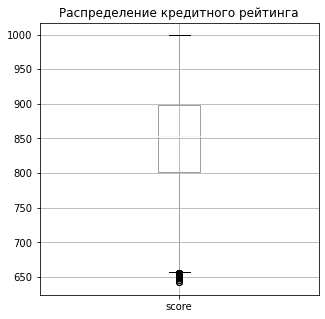

In [60]:
data.boxplot('score', figsize=(5, 5))
plt.title('Распределение кредитного рейтинга')
plt.show()

Распределение имеет вид близкий к нормальному. Посмотрим на выборочные средние

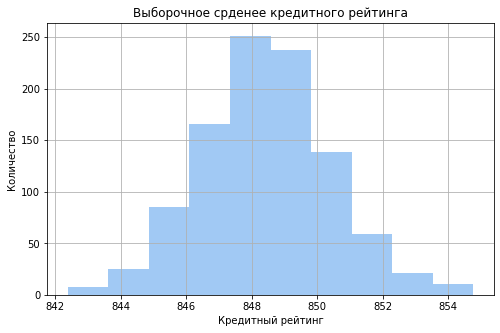

In [61]:
score_all = data['score']
mean_score_all = []
for _ in range(1000):
    mean_score_all.append(score_all.sample(1000).mean())
pd.Series(mean_score_all).hist()
plt.title('Выборочное срденее кредитного рейтинга')
plt.xlabel('Кредитный рейтинг')
plt.ylabel('Количество')
plt.show()

Распределние выборочного среднего походит на нормальное. Проверим статестически

In [62]:
alpha = 0.05 
results = st.shapiro(mean_score_all)
p_value = results[1]  
print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')   


p-значение:  0.4199424088001251
Не получилось отвергнуть нулевую гипотезу, всё нормально


**Будем проводить t тест**, так как сильных выбросов нет, имеет дело с количественными (не параметрическими) данными, размеры выборок сильно отличаются, данные выборочные средние распределены нормально. Второй момент: слишком большие разницы в объеме выборок - Манна Уитни при таких вводных может давать некорректные результаты.

In [63]:
score_churn = data['score'][data['churn'] == 1]
score_non_churn = data['score'][data['churn'] == 0]

In [64]:
alpha = 0.05 # 
results = st.ttest_ind(score_churn, score_non_churn, equal_var = False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя') 


p-значение: 1.8628446120907742e-35
Отвергаем нулевую гипотезу: разница статистически значима



<div style="border:solid Gold; padding: 40px">  
    
Результаты теста говорят о том, что получить случайно такое различие между средними значениями score для ушедших и оставшихся пользователей крайне мала, поэтому мы отвергаем гипотезу о равенстве этих значений.  
    Примечательно, что уходят в среденм люди с кредитным рейтингом выше тех, кто остаётся.

# 3.3 Анализ категорий клиентов, склонных к уходу <a id="portret"></a>  

**Посмотрим на разные факторы и как они связаны со средним значением ухода клиета из банка**

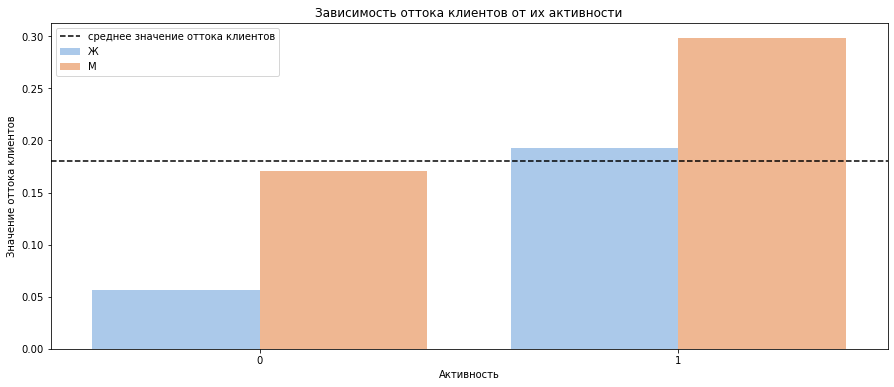

In [65]:
plt.figure(figsize = (15,6))
sns.barplot(data=data, x = 'last_activity', y='churn', ci=False, hue='gender', palette='pastel')
plt.axhline(churn_mean, color='black', linestyle='--', label = 'среднее значение оттока клиентов')
plt.title('Зависимость оттока клиентов от их активности')
plt.xlabel('Активность')
plt.ylabel('Значение оттока клиентов')
plt.legend()
plt.show()

Отток активных клиентов за отчётный период для мужчин выше среднего по всем клиентам. Неактивные уходят реже

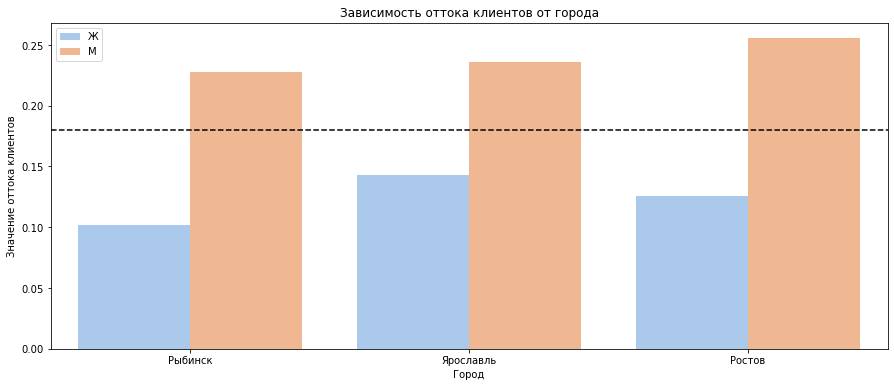

In [66]:
plt.figure(figsize = (15,6))
sns.barplot(data=data, x = 'city', y='churn', ci=False, hue='gender', palette='pastel')
plt.axhline(churn_mean, color='black', linestyle='--')
plt.title('Зависимость оттока клиентов от города')
plt.xlabel('Город')
plt.ylabel('Значение оттока клиентов')
plt.legend()
plt.show()

Во всех городах мужчины в среднем уходят чаще, чем женщины

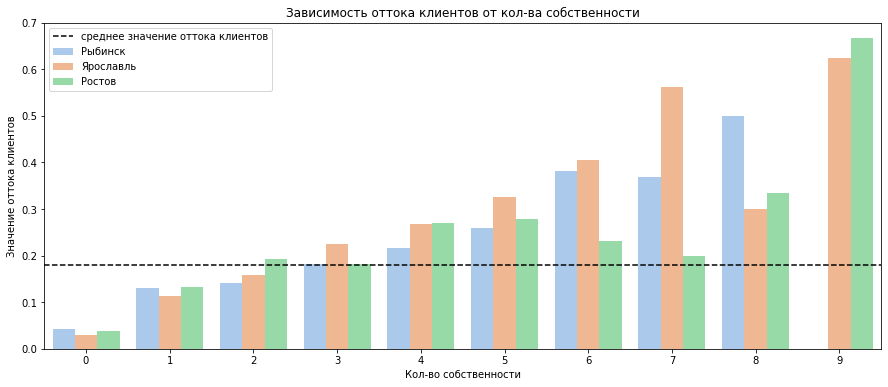

In [67]:
plt.figure(figsize = (15,6))
sns.barplot(data=data, x = 'equity', y='churn', ci=False, hue='city', palette='pastel')
plt.axhline(churn_mean, color='black', linestyle='--', label = 'среднее значение оттока клиентов')
plt.title('Зависимость оттока клиентов от кол-ва собственности')
plt.xlabel('Кол-во собственности')
plt.ylabel('Значение оттока клиентов')
plt.legend()
plt.show()

In [68]:
data.pivot_table(index='churn', values='city', columns='equity', aggfunc='count')

equity,0,1,2,3,4,5,6,7,8,9
churn,,,,,,,,,,
0,2460,672,871,1206,1360,1318,98,41,11,6
1,88,93,165,314,461,569,58,36,6,7


Чем больше собственности, тем чаще люди покидают банк. Это работает в основном для мужчин, но начиная с 5 объектов собственности для женщин тоже с небольшими исключениями

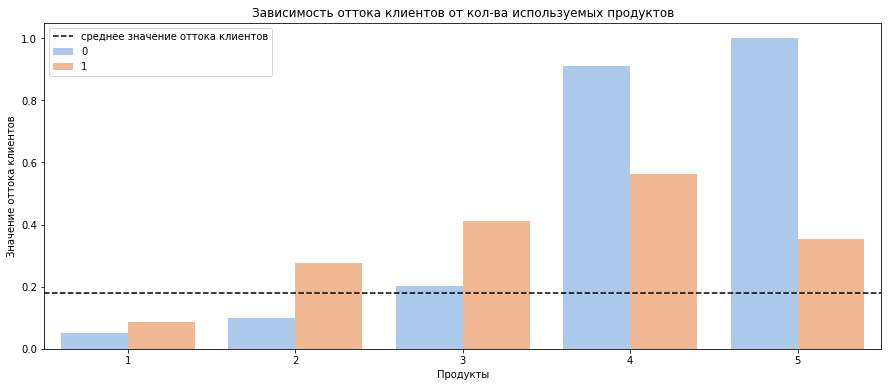

In [69]:
plt.figure(figsize = (15,6))
sns.barplot(data=data, x = 'products', y='churn', ci=False, hue='last_activity', palette='pastel')
plt.axhline(churn_mean, color='black', linestyle='--', label = 'среднее значение оттока клиентов')
plt.title('Зависимость оттока клиентов от кол-ва используемых продуктов')
plt.xlabel('Продукты')
plt.ylabel('Значение оттока клиентов')
plt.legend()
plt.show()

In [70]:
data.pivot_table(index='churn', values='last_activity', columns='products', aggfunc='count')

products,1,2,3,4,5
churn,,,,,
0,3062,4076,725,169,11
1,231,966,295,297,8


Удивительно, но чем больше продуктов, тем больше уходят клиенты банков. Для 3х и более продуктов это актуально и для женищн и для мужчин (в большей части)

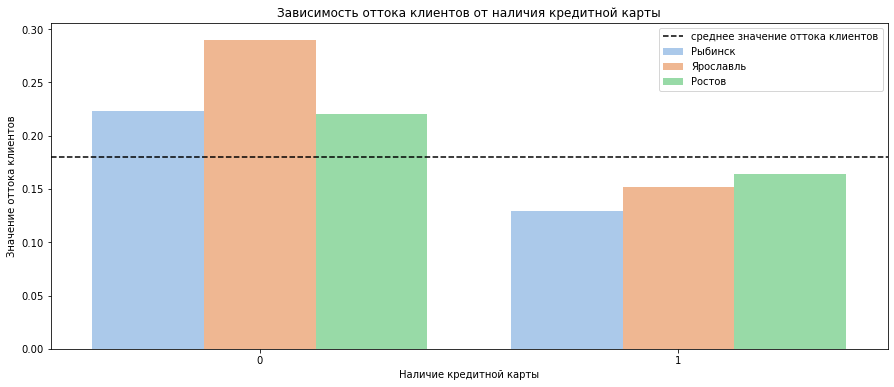

In [71]:
plt.figure(figsize = (15,6))
sns.barplot(data=data, x = 'credit_card', y='churn', ci=False, hue='city', palette='pastel')
plt.axhline(churn_mean, color='black', linestyle='--', label = 'среднее значение оттока клиентов')
plt.title('Зависимость оттока клиентов от наличия кредитной карты')
plt.xlabel('Наличие кредитной карты')
plt.ylabel('Значение оттока клиентов')
plt.legend()
plt.show()

А с наличием кредитки всё без сюрпризов. Есть кредитка - более привязан к банку. Но всё равно мужчины более склоны к оттоку

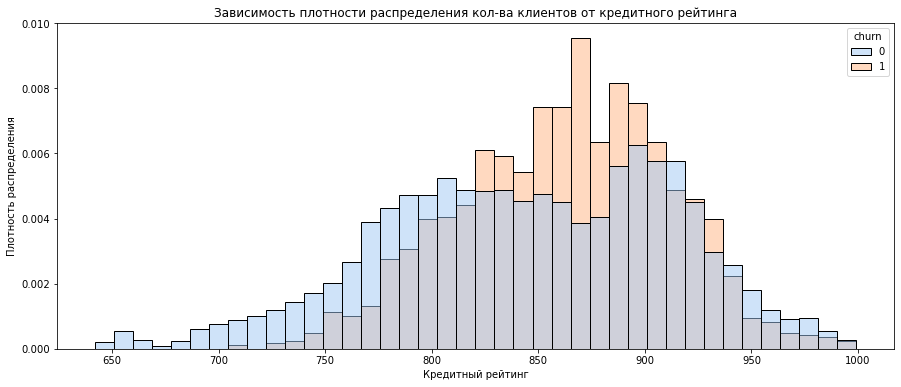

In [72]:
plt.figure(figsize = (15,6))
sns.histplot(data, x = 'score', hue='churn', stat='density', common_norm=False)
plt.title('Зависимость плотности распределения кол-ва клиентов от кредитного рейтинга')
plt.xlabel('Кредитный рейтинг')
plt.ylabel('Плотность распределения')
plt.show()

Наиболее склоны к уходу клиенты с кредитным скором выше среднего. Клиенты с низким кредитным рейтингом, видимо, держатся за тот банк, который выдал кредит/ипотеку/кредитку

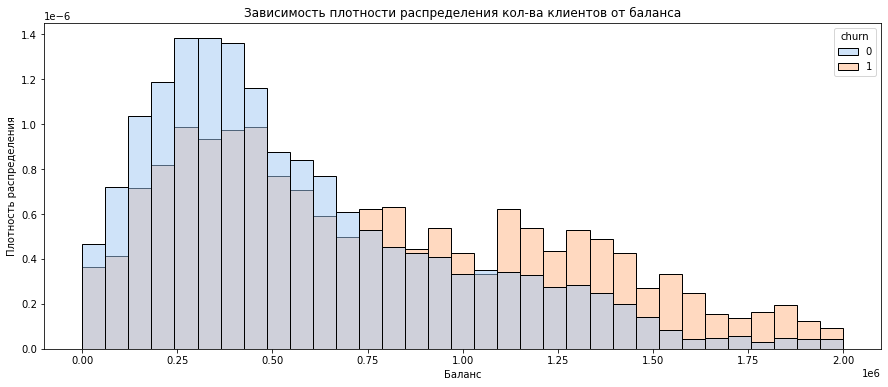

In [73]:
plt.figure(figsize = (15,6))
sns.histplot(data.query('balance<=2000000'), x = 'balance', hue='churn', stat='density', common_norm=False)
plt.title('Зависимость плотности распределения кол-ва клиентов от баланса')
plt.xlabel('Баланс')
plt.ylabel('Плотность распределения')
plt.show()

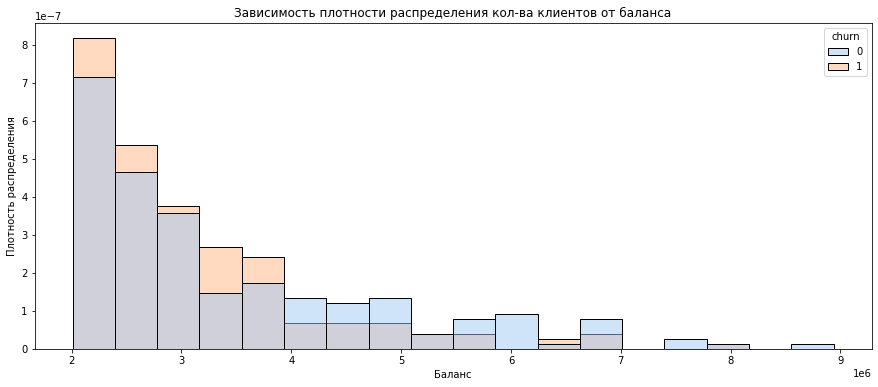

In [74]:
plt.figure(figsize = (15,6))
sns.histplot(data.query('balance>2000000'), x = 'balance', hue='churn', stat='density', common_norm=False)
plt.title('Зависимость плотности распределения кол-ва клиентов от баланса')
plt.xlabel('Баланс')
plt.ylabel('Плотность распределения')
plt.show()

Склонен к уходу больше "средний" сегмент, имеющий в среднем на балансе больше 750т.р., но меньше 4 млн. р.

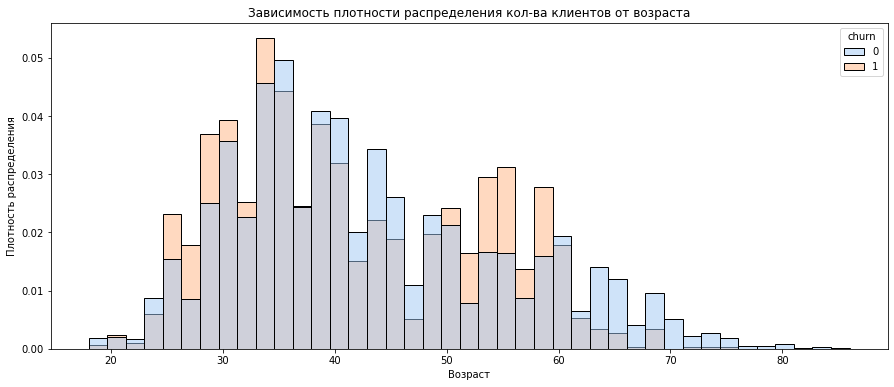

In [75]:
plt.figure(figsize = (15,6))
sns.histplot(data, x = 'age', hue='churn', stat='density', common_norm=False)
plt.title('Зависимость плотности распределения кол-ва клиентов от возраста')
plt.xlabel('Возраст')
plt.ylabel('Плотность распределения')
plt.show()

Что касается возраста, то склоны к уходу люди от 25 до 35. От 35 до 50 лет люди менее активны в плане смены банка, а после 50 и до 60 вновь активность возрастает

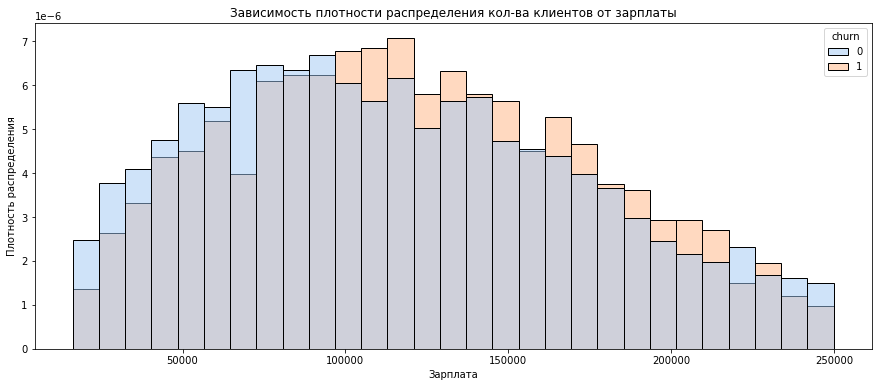

In [76]:
plt.figure(figsize = (15,6))
sns.histplot(data.query('est_salary<=250000'), x = 'est_salary', hue='churn', stat='density', common_norm=False)
plt.title('Зависимость плотности распределения кол-ва клиентов от зарплаты')
plt.xlabel('Зарплата')
plt.ylabel('Плотность распределения')
plt.show()

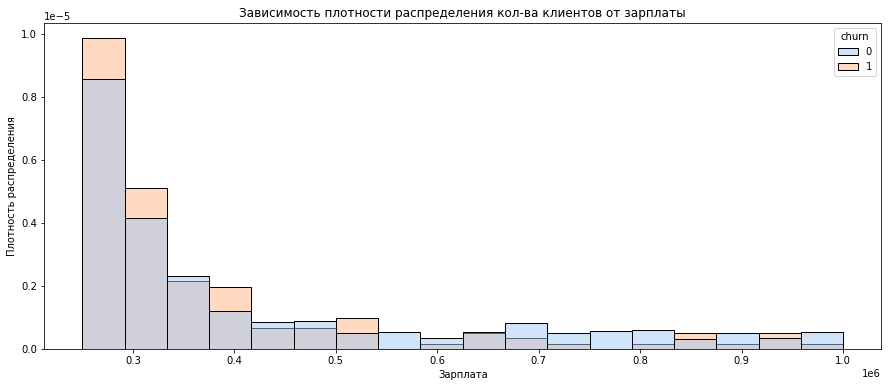

In [77]:
plt.figure(figsize = (15,6))
sns.histplot(data.query('est_salary>250000'), x = 'est_salary', hue='churn', stat='density', common_norm=False)
plt.title('Зависимость плотности распределения кол-ва клиентов от зарплаты')
plt.xlabel('Зарплата')
plt.ylabel('Плотность распределения')
plt.show()

Наиболее отточный сегмент, если смотреть на зарплату: от 100т.р. до 215т.р.

**Попробуем более детально сегментировать и подсчитать кол-во пользователь в потенциально отточных сегментах**

In [78]:
data.loc[((data['age'] >= 25) & (data['age'] <= 35)) | ((data['age'] > 50) & (data['age'] <= 60)), 'age_category'] = 'A'
data.loc[(data['score'] > 820) & (data['score'] < 910), 'score_category'] = 'A'
data.loc[(data['balance'] >= 750000) & (data['balance'] <= 4000000), 'balance_category'] = 'A'
data.loc[((data['est_salary'] >= 100000) & (data['est_salary'] <= 215000)) , 'salary_category'] = 'A'
data.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_category,score_category,balance_category,salary_category
0,183012,850.0,Рыбинск,Ж,25.0,1,59215.0,2,0,1,75719.0,1,A,A,NaN,NaN
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.0,3,1,0,86622.0,0,NaN,A,A,NaN
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.0,0,A,A,NaN,A
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.0,2,0,1,174424.0,1,A,A,A,A
4,157978,730.0,Ярославль,М,34.0,5,174.0,1,1,0,67353.0,1,A,NaN,NaN,NaN


Проверим, удалось ли нам выделить более точно сегменты клиентов, склонных к уходу

In [79]:
data_balance_category = data.pivot_table(index='churn', columns='balance_category', values='age', aggfunc='count')
data_balance_category.loc['ratio'] = data_balance_category.loc[1] / data_balance_category.loc[0]
data_balance_category

balance_category,A
churn,
0,1677.000000
1,900.000000
ratio,0.536673


In [80]:
data_balance = data.pivot_table(index='churn',  values='balance', aggfunc='count')
data_balance.loc['ratio'] = data_balance.loc[1] / data_balance.loc[0]
data_balance

,balance
churn,
0,5799.000000
1,1786.000000
ratio,0.307984


Для баланса выделенный сегмент даёт на 23% больше уходов. Потенциально отточный сегмент

In [81]:
data_salary_category = data.pivot_table(index='churn', columns='salary_category', values='age', aggfunc='count')
data_salary_category.loc['ratio'] = data_salary_category.loc[1] / data_salary_category.loc[0]
data_salary_category

salary_category,A
churn,
0,3668.000000
1,946.000000
ratio,0.257906


In [82]:
data_salary = data.pivot_table(index='churn',  values='est_salary', aggfunc='count')
data_salary.loc['ratio'] = data_salary.loc[1] / data_salary.loc[0]
data_salary

,est_salary
churn,
0,8043.000000
1,1797.000000
ratio,0.223424


Для зарплат разница в 3%

In [83]:
data_score_category = data.pivot_table(index='churn', columns='score_category', values='age', aggfunc='count')
data_score_category.loc['ratio'] = data_score_category.loc[1] / data_score_category.loc[0]
data_score_category

score_category,A
churn,
0,3515.000000
1,1126.000000
ratio,0.320341


In [84]:
data_score = data.pivot_table(index='churn',  values='score', aggfunc='count')
data_score.loc['ratio'] = data_score.loc[1] / data_score.loc[0]
data_score

,score
churn,
0,8043.000000
1,1797.000000
ratio,0.223424


Для кредитного рейтинга - 10%

In [85]:
data_age_category = data.pivot_table(index='churn', columns='age_category', values='user_id', aggfunc='count')
data_age_category.loc['ratio'] = data_age_category.loc[1] / data_age_category.loc[0]
data_age_category

age_category,A
churn,
0,3472.000000
1,1082.000000
ratio,0.311636


In [86]:
data_age = data.pivot_table(index='churn',  values='age', aggfunc='count')
data_age.loc['ratio'] = data_age.loc[1] / data_age.loc[0]
data_age

,age
churn,
0,8018.000000
1,1796.000000
ratio,0.223996


Для возраста - 9 %.

In [87]:
data.groupby('churn')['salary_category'].count()

churn
0    3681
1     946
Name: salary_category, dtype: int64

In [88]:
data.groupby('churn')['score_category'].count()

churn
0    3524
1    1127
Name: score_category, dtype: int64

Исходя из выделенных наиболее отточных категорий с учётом корреляции параметров между собой, создадим два фильтра, объединяющие в первом фильтре отточную категорию кредитного рейтинга и баланса, во втором фильтре зарплатную и возратсную отточные категории.

In [89]:
filtred_data1 = data[(data['score_category'] == 'A') & (data['balance_category'] == 'A')]
filtred_data1.groupby('churn')['user_id'].count()

churn
0    855
1    568
Name: user_id, dtype: int64

In [90]:
filtred_data2 = data[(data['age_category'] == 'A') & (data['salary_category'] == 'A')]
filtred_data2.groupby('churn')['user_id'].count()

churn
0    1395
1     535
Name: user_id, dtype: int64

Итого 3353 человека в отточных категориях.
Посмотрим, как эти категории взаимодействуют с остальными параметрами

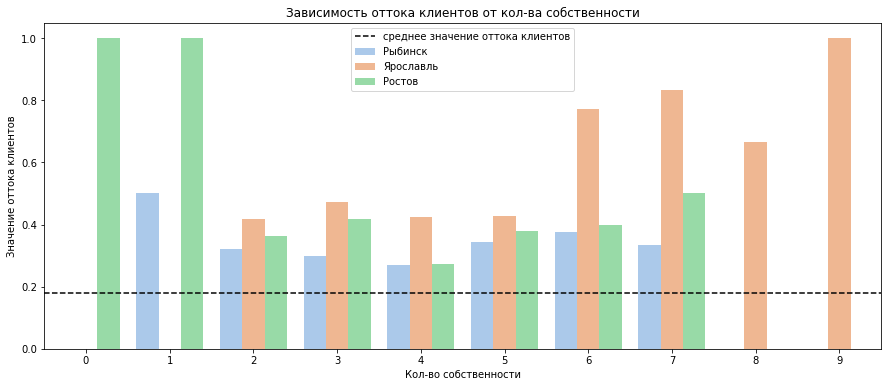

In [91]:
plt.figure(figsize = (15,6))
sns.barplot(data=filtred_data1 , x = 'equity', y='churn', ci=False, hue='city', palette='pastel')
plt.axhline(churn_mean, color='black', linestyle='--', label = 'среднее значение оттока клиентов')
plt.title('Зависимость оттока клиентов от кол-ва собственности')
plt.xlabel('Кол-во собственности')
plt.ylabel('Значение оттока клиентов')
plt.legend()
plt.show()

In [92]:
filtred_data1.pivot_table(index='churn', values='city', columns='equity', aggfunc='count')

equity,0,1,2,3,4,5,6,7,8,9
churn,,,,,,,,,,
0,1,6,56,136,264,373,13,4,1,1
1,1,2,35,99,151,248,22,7,2,1


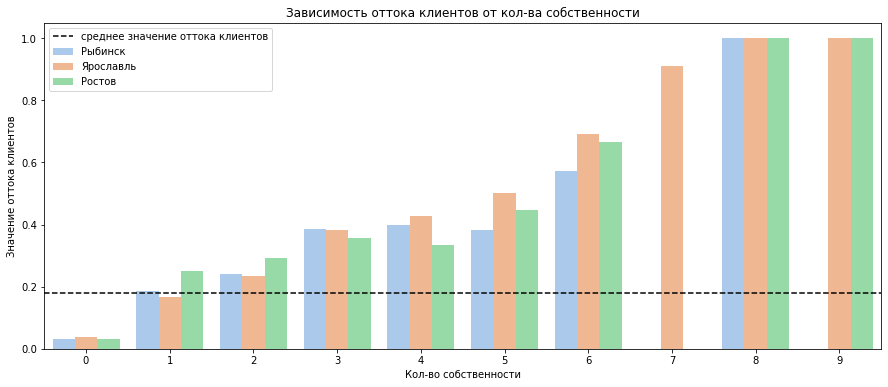

In [93]:
plt.figure(figsize = (15,6))
sns.barplot(data=filtred_data2 , x = 'equity', y='churn', ci=False, hue='city', palette='pastel')
plt.axhline(churn_mean, color='black', linestyle='--', label = 'среднее значение оттока клиентов')
plt.title('Зависимость оттока клиентов от кол-ва собственности')
plt.xlabel('Кол-во собственности')
plt.ylabel('Значение оттока клиентов')
plt.legend()
plt.show()

In [94]:
filtred_data2.pivot_table(index='churn', values='city', columns='equity', aggfunc='count')

equity,0,1,2,3,4,5,6,7,8,9
churn,,,,,,,,,,
0,576.0,99.0,146.0,153.0,218.0,193.0,8.0,2.0,NaN,NaN
1,21.0,23.0,47.0,94.0,152.0,167.0,15.0,10.0,4.0,2.0


Если сравнивать полученные графики на отфильтрованных данных и график оттока в зависимости от кол-ва собственности выше, то можно убедиться, что срез работает корректно и для всех категорий процент ушедших увеличился. Обращает на себя внимание, что сильно были срезаны клиенты с 0 и 1 собственностью, это подверждает предположение, что люди с маленьким кол-ом собственности реже уходят из банка

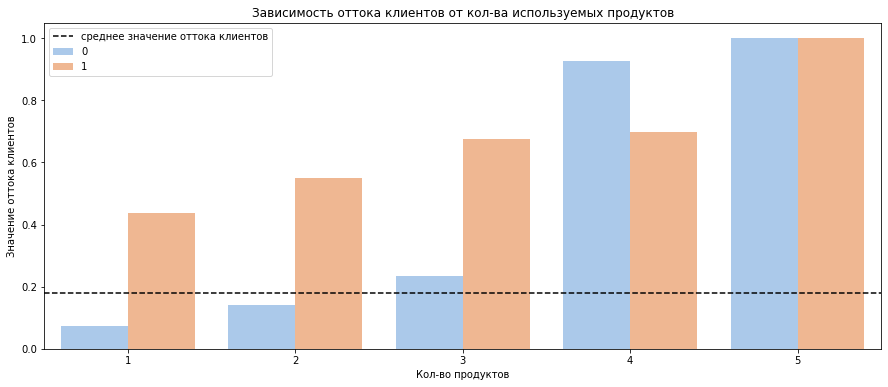

In [95]:
plt.figure(figsize = (15,6))
sns.barplot(data=filtred_data1, x = 'products', y='churn', ci=False, hue='last_activity', palette='pastel')
plt.axhline(churn_mean, color='black', linestyle='--', label = 'среднее значение оттока клиентов')
plt.title('Зависимость оттока клиентов от кол-ва используемых продуктов')
plt.xlabel('Кол-во продуктов')
plt.ylabel('Значение оттока клиентов')
plt.legend()
plt.show()

In [96]:
filtred_data1.pivot_table(index='churn', values='last_activity', columns='products', aggfunc='count')

products,1,2,3,4,5
churn,,,,,
0,129.0,582.0,108.0,36.0,NaN
1,38.0,332.0,79.0,114.0,5.0


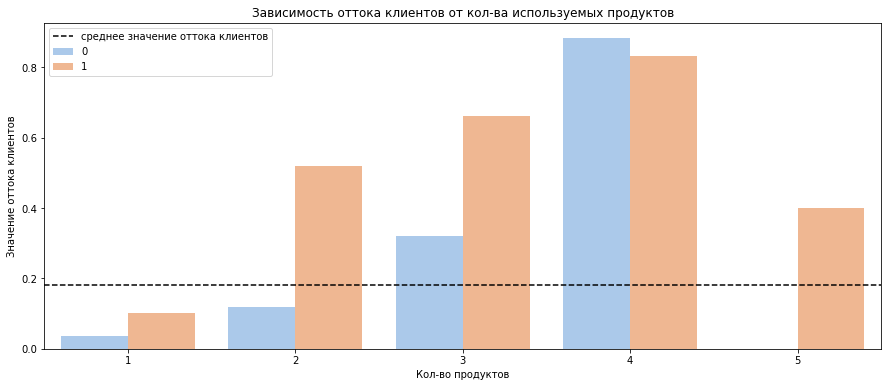

In [97]:
plt.figure(figsize = (15,6))
sns.barplot(data=filtred_data2, x = 'products', y='churn', ci=False, hue='last_activity', palette='pastel')
plt.axhline(churn_mean, color='black', linestyle='--', label = 'среднее значение оттока клиентов')
plt.title('Зависимость оттока клиентов от кол-ва используемых продуктов')
plt.xlabel('Кол-во продуктов')
plt.ylabel('Значение оттока клиентов')
plt.legend()
plt.show()

In [98]:
filtred_data2.pivot_table(index='churn', values='last_activity', columns='products', aggfunc='count')

products,1,2,3,4,5
churn,,,,,
0,641,644,92,15,3
1,49,321,79,84,2


Построенные графики по отфильттрованным данным демонстрируют по всем категорям products увеличение отточных клиентов.

<div style="border:solid Gold; padding: 40px">   
    
 **Исходя из исследования, можно составить следующий портрет отточных клиентов:**
     
1. Наиболее склоны к уходу мужчины
2. Самый отточный возраст: 25-35 и 51-60
3. Уходят чаще люди со средним балансом от 750 т.р. до 4 млн
4. Уходят чаще люди с кредитным рейтингом выше среднего: 820-910
5. Склоны к уходу люди со средней зарплатой: 100т.р.-215т.р.
6. Как правило, уходящие клиенты пользуются тремя и более продуктами
7. Активные клиенты в среднем чаще покидают банк
8. У уходящих клиентов чаще всего есть в собственности два и более объекта. При этом люди с большим количеством собственности более склоны к уходу, чем те, у кого её нет.
9. Люди, не имеющие кредитки - более склоны к уходу.
10. Клиенты склоны уходить из всех городов, но чуть больше процент у Ростова.

<div style="border:solid Gold; padding: 40px"> 
    
 **Из проведенного исследования также можно составить портрет клиента, несклонного к уходу:**
     
1. Наиболее склоны к тому, чтобы не менять банк - женщины.
2. Как правило оставшиеся клиенты менее активны.
3. Клиент имеет кредитную карту.
4. Реже других уходят люди в возрасте 35-50 лет, а также старшее поколение (61+).
5. Чем меньше у клиента собственности, тем меньше шанс, что он уйдёт.
6. Оставшиеся клиенты чаще имеют баланс либо низкий (до 750 т.р.), либо высокий (более 4 млн.).
7. Уходят реже клиенты с кредитным низким рейтингом (до 800) и высоким кредитным рейтингом (более 910)
8. Менее склоны к уходу люди со средней зарплатой до 100т.р. и больше 400т.р.
9. Как правило, оставшиеся клиенты пользуются не более, чем 2-мя продуктами.


# 4. Выводы и рекомендации <a id="conclusion"></a>  

<div style="border:solid Gold; padding: 40px">   

**Исходя из проведённого исследования оттока клиентов из регионального банка можно сделать следующие выводы:**     
1) Нет прямой сильной зависимости между уходом клиентов и каким то одним фактором. Наибольшая корреляция между уходом и кол-ом собственности, а также кол-ом используемых продуктов банка.

2) Были проверены следующие гипотезы:  
     2.1) Средние значениях доходов ушедших клиентов и тех, кто остались не отличаются. Не удалось найти статистически значимых различий в зарплатах оставшихся и ушедших клиентов.  
     2.2) Средние значения кредитного рейтинга (score) ушедших и оставшихся клиентов не отличаются. Гипотеза не подтвердилась, статистически значимые различия в средних значения кредитного рейтинга ушедших и оставшихся клиентов присутствуют. Уходят люди с кредитным рейтингом выше, чем те, кто остаются.  

3) Основные признаки клиентов, наиболее склонных к уходу:  
    3.1) мужчины уходят чаще, чем женщины;  
    3.2) возрастная категория 25-35 либо 51-60;  
    3.3) баланс в банке 750т.р-4 млн.;  
    3.4) имеет в собственности 2 и более объекта. Чем больше собственности, тем больше шанс, что клиент уйдёт;  
    3.5) пользуется 2-мя и более продуктами. Чем большим кол-ом продуктов клиент пользуется, тем больше шанс, что он уйдёт;  
    3.6) был активен за последний период;  
    3.7) не имеет кредитной карты;  
    3.8) кредитный рейтинг выше среднего.  

*Таким образом, наиболее склоны к уходу люди с хорошим достатком, имеющие достаточно большие балансы в банке и большое кол-во собственности, то есть средний класс. Эти люди, как правило, имеют хороший кредитный рейтинг и активно пользуются инструментами банка. Напротив, люди с низким уровнем благосостояния или с очень высоким уровнем благосостояния реже других уходят из банка.*  
    
*Портрет оставшегося клиента выглядит противоположным образом: это или человек с низким достатком и благосостоянием, либо человек с очень высоким уровнем благосостояния. При этом оставшиеся клиенты чаще не активны и реже пользуются большим кол-ом продуктов. Возможно, это связано с тем, что многие из тех, кто остаётся - люди возраста 61+. Другая болльшая группа это люди среднего возраста: 35-50 лет.*

<div style="border:solid Gold; padding: 40px">   

**Рекомендации менеджменту банка:**  
1) Обратить внимание на совместимость продуктов банка. Ситуация, когда чем больше продуктов использует клиент, тем чаще он уходит - не нормальная. Возможно, стоит лучше наладить обратную связь и тех. поддержку клиентов.  
2) Проработать специальные предложения для возрастных категорий 25-35 лет и 51-60 лет. Как правило, эти категории клиентов имеют хорошие балансы в банке, в связи с чем имеет смысл направить ресурсы на то, чтобы эти клиенты остались в банке.  
3) Активней продвигать среди отточных категорий клиентов кредитные карты, предлагать льготные условия, так как наличие кредитной карты уменьшает риск ухода клиентов.  
4) Уделить особое внимание клиентам с балансами выше среднего (750т.р.-4млн). Возможно имеет смысл для таких клиентов повысить ставку депозитов, чтобы уменьшить их отток.  
5) Проработать специальные предложения для мужчин с большим кол-ом собственности, высокой зарплатой и балансом. Возможно предложить какие то особые условия по кредитованию бизнеса или управлению финансовыми активами.  
6) Обратить внимание на клиентов с кредитным рейтингом выше среднего. В случае если на рынке имеются предложения по рефинансированию с лучшими условиям, то имеет смысл предлагать таким клиентам улучшение условий.